# Devlog 2023-07-13

Now that we have done a compatibility pass with all of the system modules, let's do a compatibility test. The results of this test should comport with [the analysis in this spreadsheet](https://docs.google.com/spreadsheets/d/1FF_ovXYQUb65JagcLj8QCmCzs2_Pzd9qnZ5Cr28v4jw/edit?usp=sharing).

Generate the cross product of all available modules and test them one-by-one to see if they run successfully. We'll just run each simulation for a few days and verify that this doesn't throw any exceptions. Ideally, these results will line up with our expected compatibility matrix.

_Note: also requires the `seaborn` library._

In [2]:
import multiprocessing
import time
from datetime import date
from itertools import product
from typing import NamedTuple

import numpy as np
import pandas as pd

from epymorph import *
from epymorph.geo.dynamic import DynamicGeo
from epymorph.initializer import DEFAULT_INITIALIZER
from epymorph.params import Params

geo_order = ['pei', 'single_pop', 'us_counties_2015',
             'us_states_2015', 'us_sw_counties_2015', 'maricopa_cbg_2019']
mm_order = ['pei', 'sparsemod', 'centroids', 'icecube', 'no']
ipm_order = ['pei', 'sirs', 'sirh', 'sparsemod', 'no']

# pre-load the geos, otherwise we'll waste time reloading these for every simulation
cached_geos = {
    name: geo_library[name]()
    for name in geo_order
}

for g in cached_geos:
    if isinstance(g, DynamicGeo):
        g.fetch_all()


# Params to satisfy (almost) every combo!
params: Params = {
    'alpha': [0.05, 0.4125, 0.5875],
    'beta': 0.4,
    'gamma': 0.1000022,
    'xi': 1 / 90.0,
    'phi': 40,
    'theta': 0.1,
    'move_control': 0.9,
    'infection_duration': 4.0,
    'immunity_duration': 90.0,
    'hospitalization_duration': 14.0,
    'hospitalization_rate': 0.1,
    # initializer: single_location
    'location': 0,
    'seed_size': 100,
}

sparsemod_ipm_params: Params = {
    'omega': [0.55, 0.05],
    'delta': [0.333, 0.5, 0.166, 0.142, 0.125],
    'gamma': [0.166, 0.333, 0.25],
    'rho': [0.40, 0.175, 0.015, 0.20, 0.60],
}


class Result(NamedTuple):
    geo: str
    mm: str
    ipm: str
    runs: bool
    runtime: float
    error: str | None


def test(geo: str, mm: str, ipm: str, lock) -> Result:
    tf = TimeFrame(date(2010, 1, 1), 3)
    t0 = time.perf_counter()

    try:
        if ipm == 'sparsemod':
            ps = params | sparsemod_ipm_params
        else:
            ps = params

        sim = StandardSimulation(
            geo=cached_geos[geo],
            ipm=ipm_library[ipm](),
            mm=mm_library[mm](),
            params=ps,
            time_frame=tf,
            initializer=DEFAULT_INITIALIZER,
            rng=lambda: np.random.default_rng()
        )
        sim.validate()
        sim.run()

        success = True
        error = None
    except Exception as e:
        success = False
        error = repr(e)

    t1 = time.perf_counter()
    with lock:
        print(
            f"{'succeeded' if success else 'failed'}: {geo, mm, ipm} in {((t1 - t0) * 1000.0):.3f} ms")
    return Result(geo, mm, ipm, success, t1 - t0, error)


with multiprocessing.Manager() as manager:
    lock = manager.Lock()

    with multiprocessing.Pool(processes=multiprocessing.cpu_count()) as pool:
        combos = ((*args, lock) for args in product(geo_order, mm_order, ipm_order))
        results = pool.starmap(test, combos)

compat = pd.DataFrame(results)

succeeded: ('pei', 'no', 'no') in 24.901 ms
succeeded: ('single_pop', 'centroids', 'no') in 35.918 ms
succeeded: ('pei', 'sparsemod', 'no') in 42.115 ms
failed: ('single_pop', 'no', 'pei') in 82.326 ms
succeeded: ('pei', 'no', 'sirs') in 99.263 ms
succeeded: ('pei', 'sparsemod', 'sirs') in 442.196 ms
failed: ('single_pop', 'sparsemod', 'pei') in 444.142 ms
succeeded: ('single_pop', 'centroids', 'sirs') in 444.483 ms
failed: ('single_pop', 'icecube', 'pei') in 396.904 ms
succeeded: ('single_pop', 'no', 'sirs') in 347.286 ms
succeeded: ('pei', 'pei', 'pei') in 472.512 ms
succeeded: ('pei', 'icecube', 'pei') in 473.312 ms
failed: ('single_pop', 'pei', 'pei') in 437.480 ms
succeeded: ('pei', 'centroids', 'pei') in 410.447 ms
succeeded: ('pei', 'centroids', 'sirh') in 548.817 ms
succeeded: ('single_pop', 'sparsemod', 'sirs') in 30.038 ms
succeeded: ('single_pop', 'icecube', 'sirs') in 27.248 ms
succeeded: ('pei', 'pei', 'sirs') in 46.634 ms
succeeded: ('pei', 'icecube', 'sirs') in 28.626 ms

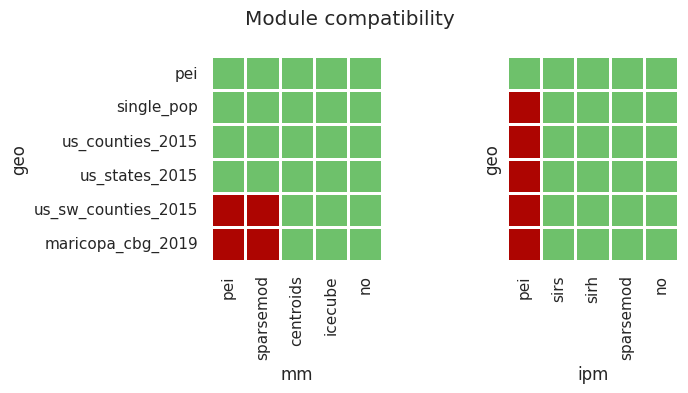

In [3]:
from functools import partial, reduce

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

boolean_or = partial(reduce, bool.__or__)


mm_compat = compat.groupby(by=['geo', 'mm'])\
    .agg({'runs': boolean_or})\
    .reset_index()\
    .pivot(index='geo', columns='mm', values='runs')\
    .reset_index()\
    .reindex(columns=['geo', *mm_order])\
    .sort_values(by='geo', key=lambda x: x.map({k: v for v, k in enumerate(geo_order)}))\
    .set_index('geo')

# display(mm_compat)


ipm_compat = compat.groupby(by=['geo', 'ipm'])\
    .agg({'runs': boolean_or})\
    .reset_index()\
    .pivot(index='geo', columns='ipm', values='runs')\
    .reset_index()\
    .reindex(columns=['geo', *ipm_order])\
    .sort_values(by='geo', key=lambda x: x.map({k: v for v, k in enumerate(geo_order)}))\
    .set_index('geo')

# display(ipm_compat)

palette = ['#AD0501', '#6EC16B']

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharey=True)

sns.heatmap(mm_compat,
            cmap=palette,
            cbar=False,
            square=True,
            linewidths=1,
            ax=ax1)

sns.heatmap(ipm_compat,
            cmap=palette,
            cbar=False,
            square=True,
            linewidths=1,
            ax=ax2)

plt.suptitle("Module compatibility")
plt.tight_layout()
plt.show()

# NOTE: and when I ran this, it matched my expectations as laid out in this spreadsheet:
# https://docs.google.com/spreadsheets/d/1FF_ovXYQUb65JagcLj8QCmCzs2_Pzd9qnZ5Cr28v4jw/edit?usp=sharing

In [4]:
# What are the slowest sims (that succeed)?
compat\
    .loc[compat['runs'] == True]\
    .sort_values(by='runtime', ascending=False)\
    .reset_index(drop=True)

,geo,mm,ipm,runs,runtime,error
0,us_sw_counties_2015,centroids,sirs,True,36.494279,None
1,us_counties_2015,centroids,sparsemod,True,36.335778,None
2,us_counties_2015,sparsemod,sirh,True,34.959409,None
3,us_sw_counties_2015,centroids,no,True,34.806786,None
4,us_counties_2015,centroids,sirs,True,29.159343,None
...,...,...,...,...,...,...
102,pei,no,no,True,0.024901,None
103,us_states_2015,no,no,True,0.024564,None
104,single_pop,no,no,True,0.023095,None
105,single_pop,sparsemod,no,True,0.023092,None
